imports:

In [3]:
import os, sys
import pandas as pd
import io
import numpy as np
import math
from typing import Optional
from dataclasses import dataclass
from math import sqrt
from statistics import mean

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules.transformer import MultiheadAttention, _get_activation_fn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots

!pip install kaleido
import kaleido
#!pip install pfns
#import pfns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.3 MB/s eta 0:00:00


set wd

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

os.chdir("/content/gdrive//MyDrive/CDBN") # change to your directory
print("The path is:", os.getcwd() )
print("All the files are: ",os.listdir())

random_state = 612

Mounted at /content/gdrive/
The path is: /content/gdrive/MyDrive/CDBN
All the files are:  ['genotypes', 'fullDatasetSY.csv', 'phenotypes', 'fullDatasetSW.csv', 'fullDatasetDM.csv', 'fullDatasetDF.csv', 'NN_Results.csv', 'nested_cross_validation_results_0.csv', 'nested_cross_validation_results_1.csv', 'nested_cross_validation_results_2.csv', 'nested_cross_validation_accuracies.csv', 'Models.ipynb']


Load Data

In [5]:
data = pd.read_csv("fullDatasetSY.csv")
data.columns = data.columns.str.strip()

envs = data["1"].unique()
data = data.drop(list(data)[0:2], axis=1) #remove useless columns

nSNPs = len(data.columns) -2
print("there are",len(data["1"].unique()), "locations")
print("there are", len(data["2"].unique()),"genotypes")
print("there are",(len(data.columns) -2), "SNP markers")
print("there are",len(data),"total observations across all environments")

there are 21 locations
there are 327 genotypes
there are 1138 SNP markers
there are 4691 total observations across all environments


View data

In [ ]:
data

1         2     3    4    5    6    7    8    9   10  ...  1127  1128  \
0     CO  CDBN_054  84.0  0.0  2.0  2.0  2.0  0.0  2.0  2.0  ...   0.0   2.0   
1     CO  CDBN_351  85.0  1.0  2.0  2.0  2.0  2.0  0.0  0.0  ...   0.0   2.0   
2     CO  CDBN_171  80.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0  ...   0.0   2.0   
3     CO  CDBN_345  84.0  1.0  0.0  1.0  2.0  0.0  1.0  1.0  ...   0.0   2.0   
4     CO  CDBN_332  82.0  0.0  0.0  2.0  2.0  0.0  2.0  2.0  ...   0.0   2.0   
...   ..       ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
3521  TX  CDBN_308  96.0  2.0  0.0  2.0  2.0  0.0  2.0  1.0  ...   0.0   2.0   
3522  TX  CDBN_309  91.0  2.0  2.0  1.0  1.0  2.0  0.0  0.0  ...   0.0   2.0   
3523  TX  CDBN_313  83.0  1.0  2.0  0.0  0.0  2.0  0.0  2.0  ...   0.0   2.0   
3524  TX  CDBN_315  88.0  2.0  2.0  2.0  1.0  2.0  0.0  0.0  ...   0.0   2.0   
3525  TX  CDBN_319  88.0  2.0  2.0  0.0  0.0  1.0  0.0  2.0  ...   0.0   2.0   

      1129  1130  1131  1132  1133  1134  1135  1136  
0      2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
1      2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
2      2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
3      2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
4      2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
...    ...   ...   ...   ...   ...   ...   ...   ...  
3521   2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
3522   2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
3523   2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
3524   2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  
3525   2.0   2.0   0.0   0.0   0.0   0.0   2.0   1.0  

[3526 rows x 1136 columns]

view data distribution

Text(0, 0.5, 'Density')

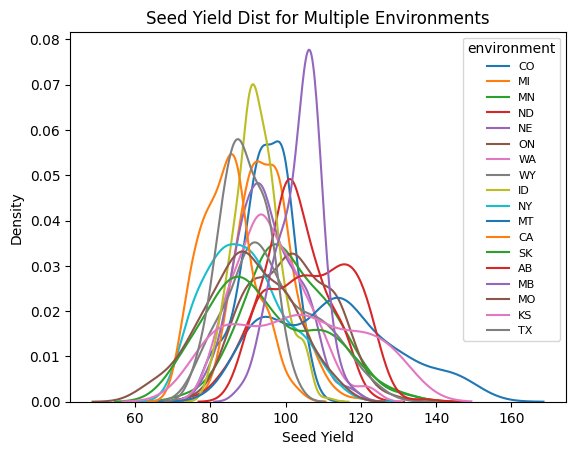

In [ ]:
reduced = data[['1','3']]

locations = data['1'].unique()

for val in locations: #view differences in envs dist
    # subset the env
    subset = reduced[reduced['1'] == val]

    # Draw the density plot
    sns.kdeplot(data = subset['3'],label=val)

plt.legend(prop={'size': 8}, title = 'environment')
plt.title('Seed Yield Dist for Multiple Environments')
plt.xlabel('Seed Yield')
plt.ylabel('Density')



view size of each environment

Text(0.5, 1.0, 'Entries Per Location')

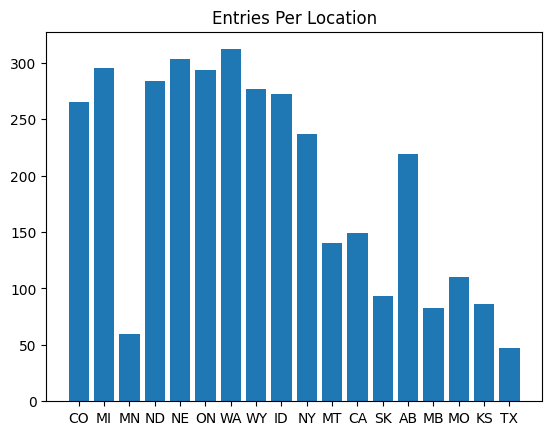

In [ ]:
entryCount = []
for loc in locations:
  nObs = reduced[reduced['1'] == loc].shape[0]
  entryCount.append(nObs)


plt.bar(locations, entryCount)
plt.title("Entries Per Location")

##scan for allelic effects?

create x y split
create train test split

In [ ]:

X = data.drop(["1","2","3"], axis=1)
X = X.replace({0.0:-1,int(1.0):0,2.0:int(1)})

X_columns = X.columns

y = np.array(data["3"])

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, shuffle=True)

xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xTest = np.array(xTest)
yTest = np.array(yTest)


class CDBNDataset(torch.utils.data.Dataset):
  '''
  Prepare the CDBN dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]


dataset = CDBNDataset(X, y)
datasetTrain = CDBNDataset(xTrain,yTrain)
datasetTest = CDBNDataset(xTest,yTest)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1,drop_last=True)
trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=10, shuffle=True, num_workers=1,drop_last=True)
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=10, shuffle=True, num_workers=1,drop_last=True)

test different values for RR alpha

In [ ]:
n_alphas = 10
alphas = np.logspace(5, -5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(xTrain, yTrain)
    coefs.append(ridge.coef_)

Visualize Ridge Coefficients

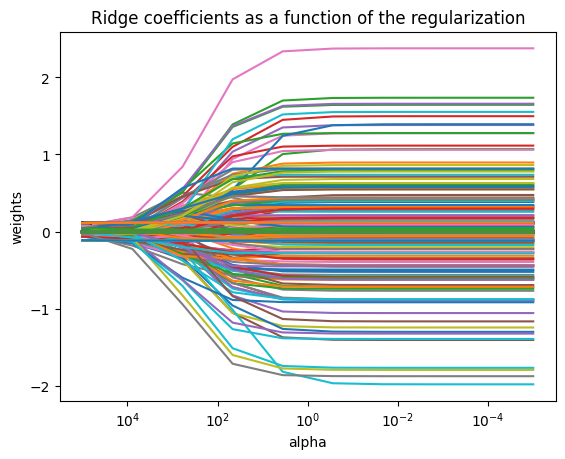

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

look at genetic makeup of each test set (location)

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

data = pd.read_csv("fullDatasetSY.csv")
data = data.drop(["Unnamed: 0","0","2","3"], axis=1) #remove useless columns
features = list(data.columns)
envs = data["1"].unique()

figs = []
val = 0
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  X = testData.drop(["1"], axis=1)
  pca = PCA(n_components=3)
  components = pca.fit_transform(X)

  total_var = pca.explained_variance_
  varC1 = total_var[0]
  varC2 = total_var[1]
  varC3 = total_var[2]

  fig = px.scatter(
    components, x=0, y=1,
    title=f'{env} ({testData.shape[0]} genotypes)',
    labels={'0': 'PC 1', '1': 'PC 2'})  # Close px.scatter here

  fig.update_layout(xaxis_title=f"PC1({varC1:.2f})", yaxis_title=f"PC2({varC2:.2f})")  # Update layout separately


  figs.append(fig)  # Append the figure to the list




for fig in figs:
    fig.show()



(1) LINEAR REGRESSION


Test bulk linear regression on every location

In [11]:
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()
scores = []

#Baseline Performance for each test env with all locations included in ens
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  X_train = trainData.drop(["Unnamed: 0","0","1","2","3"], axis=1)
  y_train = trainData["3"] #only pheno
  reg = LinearRegression()
  reg.fit(X_train, y_train)
  predictions = reg.predict(x_test)
  predictions = np.array(predictions)
  truth = np.array(y_test)
  accuracy = np.corrcoef(predictions,truth)
  accuracy = accuracy[0,1]
  scores.append(accuracy)



allAccuracies = pd.DataFrame(scores)
envs = pd.DataFrame(envs)
baselines = pd.concat([envs, allAccuracies], axis=1)

simpleLR = baselines.iloc[:,1]

baselines

0         0
0   CA  0.211889
1   CO  0.237079
2   ID  0.309538
3   MI  0.142552
4   MN  0.142835
5   MT  0.393741
6   ND  0.286290
7   NE  0.395768
8   ON  0.251250
9   WA  0.402701
10  WY  0.355380
11  NY -0.002823
12  PR  0.233904
13  AZ  0.111103
14  AB  0.301166
15  MB  0.488574
16  NM  0.313569
17  SK  0.113496
18  MO  0.026854
19  TX  0.138245
20  KS -0.033994

Establish baseline ensemble performance. Hold out one location and create an ensemble with all other locations

In [6]:
#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allAccuracies = []
baseline = {}

#Baseline Performance for each test env with all locations included in ens
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locations = trainData["1"].unique() #list of all locations in test set
  predictions = pd.DataFrame()


  #Train the ensemble
  for loc in locations:
      ensData = trainData[trainData["1"] == loc] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      reg = LinearRegression() #create model
      reg.fit(x_Train, y_Train) #fit model
      prediction = pd.DataFrame(reg.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

  #Determine accuracy of ensemble
  truth = np.array(y_test) #re-name ground truth
  finalPred = predictions.mean(axis=1) #mean pred across all models in ens
  accuracy = np.corrcoef(truth,finalPred)
  accuracy = accuracy[0,1]
  baseline[env] = accuracy

simpleLRensemble = pd.DataFrame(baseline.values())

baseline

{'CA': 0.1974664112436016,
 'CO': 0.1814956668046349,
 'ID': 0.3515268759851992,
 'MI': 0.1329398118511919,
 'MN': -0.029347816152661674,
 'MT': 0.27068478636175725,
 'ND': 0.15633882385905562,
 'NE': 0.32042466127581387,
 'ON': 0.2029132267006306,
 'WA': 0.265064360350754,
 'WY': 0.2012445735009825,
 'NY': 0.05619383018842815,
 'PR': 0.25265294370132263,
 'AZ': 0.0038644202093328665,
 'AB': 0.2486780147117801,
 'MB': 0.46495795847450405,
 'NM': 0.26546056895828213,
 'SK': 0.07047704206405252,
 'MO': 0.10870573243118864,
 'TX': 0.2108978507752369,
 'KS': -0.02860226813336886}

Leave environments out of ensemble one at a time to determine which ones should be left out of the ensemble

In [7]:
#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allLocAccuracies = {}

for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locations = trainData["1"].unique() #list of all locations in test set
  predictions = pd.DataFrame()
  allAccuracies = []

  #Train the ensemble leaving one environment out
  for loc in locations:
    ensTrainData = trainData.drop(trainData[trainData['1'] == loc].index) #remove test env from training
    trainingLocs = ensTrainData["1"].unique() #pull remaining location names
    for place in trainingLocs: #for remaining location names
      ensData = ensTrainData[ensTrainData["1"] == place] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      reg = LinearRegression() #create model
      reg.fit(x_Train, y_Train) #fit model
      prediction = pd.DataFrame(reg.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

    #Determine accuracy of ensemble without given loc
    truth = np.array(y_test) #re-name ground truth
    finalPred = predictions.mean(axis=1) #mean pred across all models in ens

    accuracy = np.corrcoef(truth,finalPred)
    allAccuracies.append(accuracy[0,1]) #collect acc for every left out location

  locations = pd.DataFrame(locations)
  allAccuracies = pd.DataFrame(allAccuracies)
  allAccuracies = pd.concat([locations,allAccuracies],axis=1)
  allLocAccuracies[env]= allAccuracies

# all loc accuracies contains the nLocations ensemble accuracies (one with each environment left out of the ensemble) predicting on each of the test environments



determine which locations lowered ensemble performance (compared to baseline ensemble with all locations)

In [8]:


Remove = {}
for env in envs:
  envBaseline = float(baseline[env])
  predictionAccuracy = allLocAccuracies[env]
  predictionAccuracy = pd.DataFrame(predictionAccuracy)
  predictionAccuracy.columns = ['loc','acc']
  remove = predictionAccuracy.loc[predictionAccuracy['acc'] > envBaseline]
  remove = list(remove['loc'])
  remove.append(env)
  removeDict =remove
  Remove[env]= removeDict


Remove

{'CA': ['CO', 'AB', 'MB', 'KS', 'CA'],
 'CO': ['CA', 'MI', 'ND', 'MO', 'CO'],
 'ID': ['KS', 'ID'],
 'MI': ['KS', 'MI'],
 'MN': ['KS', 'MN'],
 'MT': ['KS', 'MT'],
 'ND': ['KS', 'ND'],
 'NE': ['KS', 'NE'],
 'ON': ['ID', 'ON'],
 'WA': ['CA', 'KS', 'WA'],
 'WY': ['WY'],
 'NY': ['CA', 'CO', 'NM', 'NY'],
 'PR': ['CA', 'ID', 'MI', 'AB', 'MB', 'PR'],
 'AZ': ['CA', 'CO', 'MN', 'KS', 'AZ'],
 'AB': ['CA', 'CO', 'MN', 'TX', 'AB'],
 'MB': ['MO', 'MB'],
 'NM': ['MN', 'TX', 'KS', 'NM'],
 'SK': ['CA',
  'CO',
  'ID',
  'MI',
  'MN',
  'MT',
  'ND',
  'NE',
  'ON',
  'WA',
  'WY',
  'NY',
  'PR',
  'AZ',
  'MO',
  'TX',
  'SK'],
 'MO': ['WA', 'WY', 'AZ', 'MO'],
 'TX': ['CA',
  'NE',
  'ON',
  'WA',
  'WY',
  'NY',
  'PR',
  'AZ',
  'AB',
  'MB',
  'NM',
  'SK',
  'TX'],
 'KS': ['WY', 'NY', 'PR', 'AZ', 'AB', 'MB', 'NM', 'SK', 'MO', 'TX', 'KS']}

Conduct Ensemble Predictions with optimal environments

In [9]:

#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allAccuracies = []

#Baseline Performance with all locations included
val = 0
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locationsAll = trainData["1"].unique() #list of all locations in test set
  predictions = pd.DataFrame()
  withold = list(Remove[env])
  withold.append(env)
  locations = [item for item in locationsAll if item not in withold]

  #Train the ensemble
  for loc in locations:
      ensData = trainData[trainData["1"] == loc] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      reg = LinearRegression() #create model
      reg.fit(x_Train, y_Train) #fit model
      prediction = pd.DataFrame(reg.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

  #Determine accuracy of ensemble
  truth = np.array(y_test) #re-name ground truth
  finalPred = predictions.mean(axis=1) #mean pred across all models in ens
  accuracy = np.corrcoef(truth,finalPred)
  allAccuracies.append(accuracy[0,1]) #collect acc for env 1

overallAccuracy = mean(allAccuracies)

allAccuracies = pd.DataFrame(allAccuracies)
envs = pd.DataFrame(envs)
optimLRensemble = pd.concat([envs, allAccuracies], axis=1)

optimLRensemble

0         0
0   CA  0.232493
1   CO  0.233396
2   ID  0.338292
3   MI  0.153320
4   MN  0.010602
5   MT  0.297669
6   ND  0.241789
7   NE  0.328624
8   ON  0.212965
9   WA  0.299952
10  WY  0.201245
11  NY  0.068745
12  PR  0.423139
13  AZ  0.106504
14  AB  0.279213
15  MB  0.436225
16  NM  0.258695
17  SK  0.158051
18  MO  0.154101
19  TX  0.272364
20  KS  0.040618

join results and plot

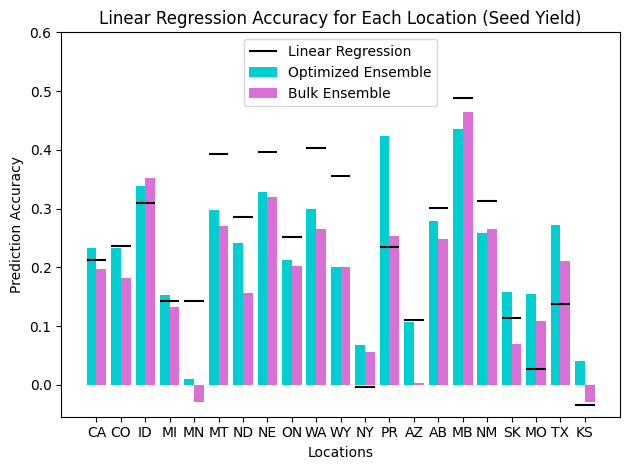

In [12]:
Result=pd.concat([optimLRensemble,simpleLRensemble,simpleLR,],axis=1)
Result.columns= ["Location","optimLRensemble","simpleLRensemble","LR"]

# Set plot parameters
fig, ax = plt.subplots()
width = 0.4 # width of bar
x = np.arange(len(Result["Location"]))  # Use numerical x-positions for the bars

ax.bar(x, Result["optimLRensemble"], width, color='darkturquoise',label = 'Optimized Ensemble')
ax.bar(x + width, Result["simpleLRensemble"], width, color='orchid', label='Bulk Ensemble')
ax.set_ylabel('Prediction Accuracy')
ax.set_xlabel('Locations')
ax.set_title('Linear Regression Accuracy for Each Location (Seed Yield)' )
ax.set_xticks(x + width / 2)  # Set x-tick positions in the middle of the grouped bars
ax.set_xticklabels(Result["Location"])  # Set x-tick labels to location names
ax.set_ylim(top=0.6)
ax.hlines(Result['LR'],xmin=x-0.2,xmax=x+0.6,colors="black",label="Linear Regression")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0))



fig.tight_layout()

look at the training set compositions

In [13]:
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd
data = pd.read_csv("fullDatasetSY.csv")
data = data.drop(["Unnamed: 0", "0", "2", "3"], axis=1) #remove useless columns
features = list(data.columns)
envs = data["1"].unique()

varC1 = []
varC2 = []
varC3 = []
figs = []
val = 0
i=0
nobs = []

for env in envs:

  withold = list(Remove[env])
  withold.append(env)
  trainingSet = data[~data["1"].isin(withold)]

  X = trainingSet.drop(["1"], axis=1)
  pca = PCA(n_components=3)
  components = pca.fit_transform(X)

  total_var = pca.explained_variance_
  varC1.append(total_var[0])
  varC2.append(total_var[1])
  varC3.append(total_var[2])
  i+=1


  fig = px.scatter(
    components, x=0, y=1,
    title=f'{env} ensemble ({trainingSet.shape[0]} observations)', color=trainingSet["1"],
    labels={'0': 'PC 1', '1': 'PC 2','2':'PC 3'}) # Close px.scatter here
  fig.update_layout(height=1750, width=1000, title_text="PCA for Each Ensemble Training Set")
  figs.append(fig)  # Append the figure to the list

  nobs.append(trainingSet.shape[0])

rows = 7
cols = 3

# Create a subplot figure to hold all the individual plots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{env} Ensemble ({nobs} Observations)" for env, nobs in zip(envs, nobs)])

shown_legends = set()
for i, figure in enumerate(figs):
    row = (i // cols) + 1
    col = (i % cols) + 1
    for trace in figure.data:
        # Show legend only if it's the first occurrence of the name
        trace.showlegend = trace.name not in shown_legends
        if trace.showlegend:
            shown_legends.add(trace.name)
        fig.add_trace(trace, row=row, col=col)

    # Add x and y axis labels to each subplot, closer to the plot
    fig.update_xaxes(title_text=f"PC1 ({varC1[i]})", row=row, col=col, title_standoff=5)
    fig.update_yaxes(title_text=f"PC2 ({varC2[i]})", row=row, col=col, title_standoff=5)

# Update the layout if necessary
fig.update_layout(
    height=1750,
    width=1000,
    title_text="PCA for Each Ensemble Training Set",
    legend=dict(x=1.05, y=0.5, xanchor='left', yanchor='middle'),
    annotations=[dict(
        font=dict(size=12)
    ) for _ in fig['layout']['annotations']]
)

fig.show()

In [15]:
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd
data = pd.read_csv("fullDatasetSY.csv")
data = data.drop(["Unnamed: 0", "0", "2", "3"], axis=1) #remove useless columns
features = list(data.columns)
envs = data["1"].unique()

varC1 = []
varC2 = []
varC3 = []
figs = []
val = 0
i=0
nobs = []

for env in envs:

  withold = list(Remove[env])
  withold.append(env)
  trainingSet = data[~data["1"].isin(withold)]

  X = trainingSet.drop(["1"], axis=1)
  pca = PCA(n_components=3)
  components = pca.fit_transform(X)

  total_var = pca.explained_variance_
  varC1.append(total_var[0])
  varC2.append(total_var[1])
  varC3.append(total_var[2])
  i+=1


  fig = px.scatter(
    components, x=1, y=2,
    title=f'{env} ensemble ({trainingSet.shape[0]} observations)', color=trainingSet["1"],
    labels={'0': 'PC 1', '1': 'PC 2','2':'PC 3'}) # Close px.scatter here
  fig.update_layout(height=1750, width=1000, title_text="PCA for Each Ensemble Training Set")
  figs.append(fig)  # Append the figure to the list

  nobs.append(trainingSet.shape[0])

rows = 7
cols = 3

# Create a subplot figure to hold all the individual plots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{env} Ensemble ({nobs} Observations)" for env, nobs in zip(envs, nobs)])

shown_legends = set()
for i, figure in enumerate(figs):
    row = (i // cols) + 1
    col = (i % cols) + 1
    for trace in figure.data:
        # Show legend only if it's the first occurrence of the name
        trace.showlegend = trace.name not in shown_legends
        if trace.showlegend:
            shown_legends.add(trace.name)
        fig.add_trace(trace, row=row, col=col)

    # Add x and y axis labels to each subplot, closer to the plot
    fig.update_xaxes(title_text=f"PC2 ({varC2[i]})", row=row, col=col, title_standoff=5)
    fig.update_yaxes(title_text=f"PC3 ({varC3[i]})", row=row, col=col, title_standoff=5)

# Update the layout if necessary
fig.update_layout(
    height=1750,
    width=1000,
    title_text="PCA for Each Ensemble Training Set",
    legend=dict(x=1.05, y=0.5, xanchor='left', yanchor='middle'),
    annotations=[dict(
        font=dict(size=12)
    ) for _ in fig['layout']['annotations']]
)

fig.show()

create distance matrices

KeyboardInterrupt: 

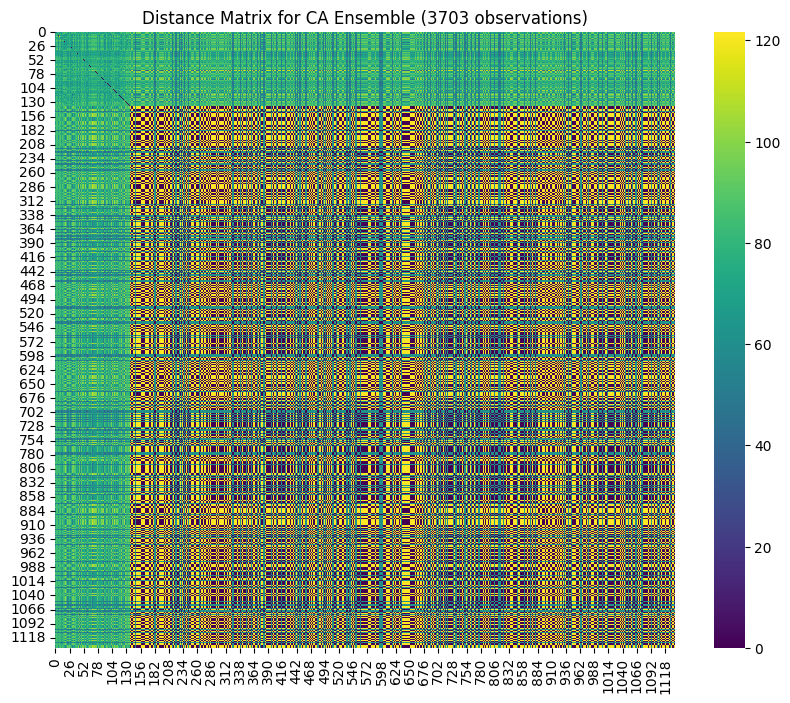

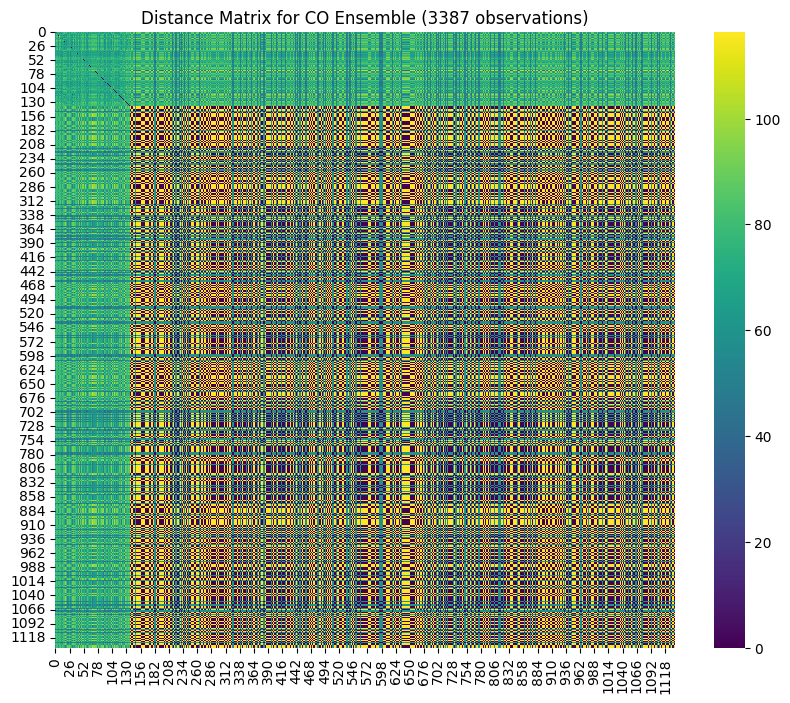

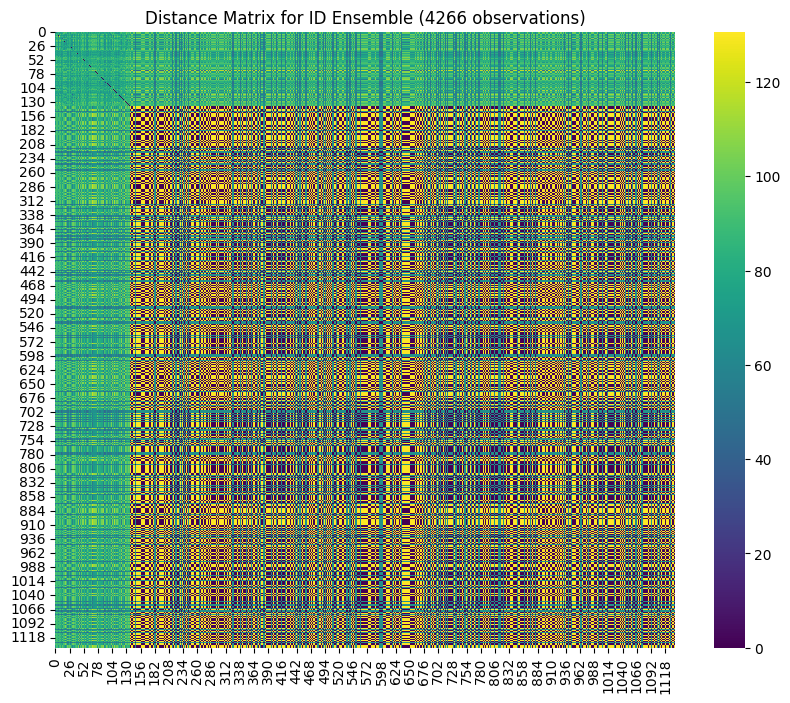

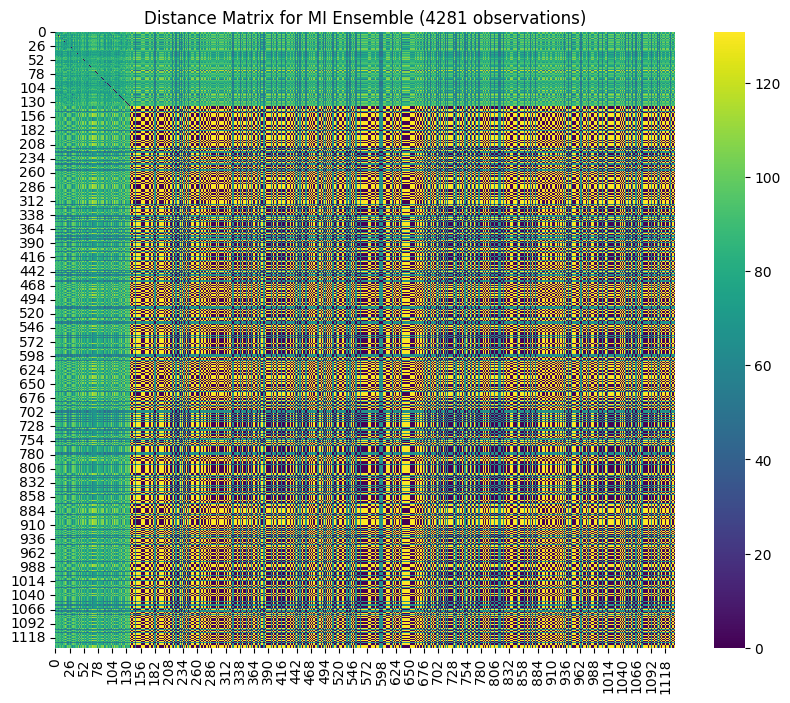

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from plotly.subplots import make_subplots

# Load the data
data = pd.read_csv("fullDatasetSY.csv")
data = data.drop(["Unnamed: 0", "0", "2", "3"], axis=1)  # Remove useless columns
features = list(data.columns)
envs = data["1"].unique()

dist_matrices = []
i = 0

for env in envs:
    withold = list(Remove[env])
    withold.append(env)
    trainingSet = data[~data["1"].isin(withold)]

    X = trainingSet.drop(["1"], axis=1).values
    X = np.transpose(X)
    dist_matrix = distance_matrix(X, X)
    dist_matrices.append(dist_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_matrix, cmap='viridis')
    plt.title(f'Distance Matrix for {env} Ensemble ({trainingSet.shape[0]} observations)')

rows = 7
cols = 3

# Create a subplot figure to hold all the individual plots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{env} Ensemble" for env in envs])

for i, dist_matrix in enumerate(dist_matrices):
    row = (i // cols) + 1
    col = (i % cols) + 1
    heatmap = sns.heatmap(dist_matrix, cmap='viridis', cbar=False).get_figure()
    fig.add_trace(
        go.Heatmap(z=dist_matrix, colorscale='Viridis', showscale=False),
        row=row, col=col
    )

# Update the layout if necessary
fig.update_layout(height=3000, width=1000, title_text="Distance Matrices for Each Ensemble Training Set",
                  legend=dict(x=1.05, y=0.5, xanchor='left', yanchor='middle'))

fig.show()


(2) RIDGE REGRESSION

Find best alpha

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=5,shuffle=True)
params ={'alpha':[0.001,0.1,10,50,100]}

model = Ridge()

model_cv  = GridSearchCV(estimator=model,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         cv=folds,
                         return_train_score=True,
                         verbose=1)
model_cv.fit(xTrain,yTrain)

print(model_cv.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'alpha': 100}


Run RR with best alpha, leaving locations out of training set one at a time

In [ ]:

data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()
scores = []

#Baseline Performance for each test env with all locations included in ens
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  X_train = trainData.drop(["Unnamed: 0","0","1","2","3"], axis=1)
  y_train = trainData["3"] #only pheno
  ridge = linear_model.Ridge(alpha=100)
  ridge.fit(X_train, y_train)
  predictions = ridge.predict(x_test)
  predictions = np.array(predictions)
  truth = np.array(y_test)
  accuracy = np.corrcoef(predictions,truth)
  accuracy = accuracy[0,1]
  scores.append(accuracy)



allAccuracies = pd.DataFrame(scores)
envs = pd.DataFrame(envs)
baselines = pd.concat([envs, allAccuracies], axis=1)

simpleRR = baselines.iloc[:,1]


Ensemble RR

Find Ensemble Baselines

In [ ]:


##################
#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allAccuracies = []
baseline = {}

#Baseline Performance for each test env with all locations included in ens
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locations = trainData["1"].unique() #list of all locations in test set
  #
  predictions = pd.DataFrame()


  #Train the ensemble
  for loc in locations:
      ensData = trainData[trainData["1"] == loc] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      ridge = linear_model.Ridge(alpha=100)
      ridge.fit(x_Train, y_Train)
      prediction = pd.DataFrame(ridge.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

  #Determine accuracy of ensemble
  truth = np.array(y_test) #re-name ground truth
  finalPred = predictions.mean(axis=1) #mean pred across all models in ens
  accuracy = np.corrcoef(truth,finalPred)
  accuracy = accuracy[0,1]
  baseline[env] = accuracy

simpleRRensemble = pd.DataFrame(baseline.values())

baseline

{'CA': 0.24287416467814274,
 'CO': 0.24998774324494918,
 'ID': 0.41132698251306093,
 'MI': 0.18945770477012752,
 'MN': 0.05639840127794597,
 'MT': 0.38393820139877793,
 'ND': 0.294934994853381,
 'NE': 0.38420181123479163,
 'ON': 0.26256624494669906,
 'WA': 0.3801253454414055,
 'WY': 0.3611894633073814,
 'NY': 0.06704757128447078,
 'PR': 0.023349472448921302,
 'AZ': 0.16154838679134823,
 'AB': 0.35761720541311653,
 'MB': 0.529191552956219,
 'NM': 0.3144698991471732,
 'SK': 0.13314183056863446,
 'MO': 0.10751982508186894,
 'TX': 0.14122175421575006,
 'KS': -0.12499865380985317}

Test ensembles leaving out one environment at a time  

In [ ]:

#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allLocAccuracies = {}

for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locations = trainData["1"].unique() #list of all locations in test set
  predictions = pd.DataFrame()
  allAccuracies = []

  #Train the ensemble leaving one environment out
  for loc in locations:
    ensTrainData = trainData.drop(trainData[trainData['1'] == loc].index) #remove test env from training
    trainingLocs = ensTrainData["1"].unique() #pull remaining location names
    for place in trainingLocs: #for remaining location names
      ensData = ensTrainData[ensTrainData["1"] == place] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      ridge = linear_model.Ridge(alpha=100)
      ridge.fit(x_Train, y_Train)
      prediction = pd.DataFrame(ridge.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

    #Determine accuracy of ensemble without given loc
    truth = np.array(y_test) #re-name ground truth
    finalPred = predictions.mean(axis=1) #mean pred across all models in ens

    accuracy = np.corrcoef(truth,finalPred)
    allAccuracies.append(accuracy[0,1]) #collect acc for every left our location

  locations = pd.DataFrame(locations)
  allAccuracies = pd.DataFrame(allAccuracies)
  allAccuracies = pd.concat([locations,allAccuracies],axis=1)
  allLocAccuracies[env]= allAccuracies

# all loc accuracies contains the 17 ensemble accuracies (one with each environment left out of the ensemble) predicting on each of the test environments



{'CA':      0         0
 0   CO  0.249428
 1   ID  0.240605
 2   MI  0.240545
 3   MN  0.242865
 4   MT  0.242219
 5   ND  0.242018
 6   NE  0.240103
 7   ON  0.240651
 8   WA  0.241817
 9   WY  0.241963
 10  NY  0.242338
 11  PR  0.242441
 12  AZ  0.243271
 13  AB  0.244308
 14  MB  0.243593
 15  NM  0.242952
 16  SK  0.243507
 17  MO  0.243159
 18  TX  0.243238
 19  KS  0.242874,
 'CO':      0         0
 0   CA  0.256322
 1   ID  0.251756
 2   MI  0.253859
 3   MN  0.250867
 4   MT  0.252464
 5   ND  0.253010
 6   NE  0.253396
 7   ON  0.253314
 8   WA  0.252547
 9   WY  0.253268
 10  NY  0.253158
 11  PR  0.252725
 12  AZ  0.252646
 13  AB  0.251411
 14  MB  0.251192
 15  NM  0.250663
 16  SK  0.250527
 17  MO  0.250206
 18  TX  0.250145
 19  KS  0.249988,
 'ID':      0         0
 0   CA  0.401266
 1   CO  0.405487
 2   MI  0.409548
 3   MN  0.410917
 4   MT  0.411465
 5   ND  0.411922
 6   NE  0.410386
 7   ON  0.412573
 8   WA  0.413921
 9   WY  0.412701
 10  NY  0.412818
 11  PR 

Determine which envs help or hinder the ensemble

In [ ]:

Remove = {}
for env in envs:
  envBaseline = float(baseline[env])
  predictionAccuracy = allLocAccuracies[env]
  predictionAccuracy = pd.DataFrame(predictionAccuracy)
  predictionAccuracy.columns = ['loc','acc']
  remove = predictionAccuracy.loc[(predictionAccuracy['acc']-.001) >= envBaseline]
  remove = list(remove['loc'])
  remove.append(env)
  removeDict =remove
  Remove[env]= removeDict



Run ensemble with optimal set

In [ ]:

#Ensemble across environments
data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()

allAccuracies = []

#Baseline Performance with all locations included
val = 0
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  locationsAll = trainData["1"].unique() #list of all locations in test set
  predictions = pd.DataFrame()
  withold = list(Remove[env])
  withold.append(env)
  locations = [item for item in locationsAll if item not in withold]

  #Train the ensemble
  for loc in locations:
      ensData = trainData[trainData["1"] == loc] #take one environment for training
      x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
      y_Train = ensData["3"] #pheno only
      ridge = linear_model.Ridge(alpha=100)
      ridge.fit(x_Train, y_Train)
      prediction = pd.DataFrame(ridge.predict(x_test)) #prediction on test
      predictions = pd.concat([predictions,prediction],axis=1) #collect predictions from each location

  #Determine accuracy of ensemble
  truth = np.array(y_test) #re-name ground truth
  finalPred = predictions.mean(axis=1) #mean pred across all models in ens
  accuracy = np.corrcoef(truth,finalPred)
  allAccuracies.append(accuracy[0,1]) #collect acc for env 1

overallAccuracy = mean(allAccuracies)

allAccuracies = pd.DataFrame(allAccuracies)
envs = pd.DataFrame(envs)
optimRRensemble = pd.concat([envs, allAccuracies], axis=1)



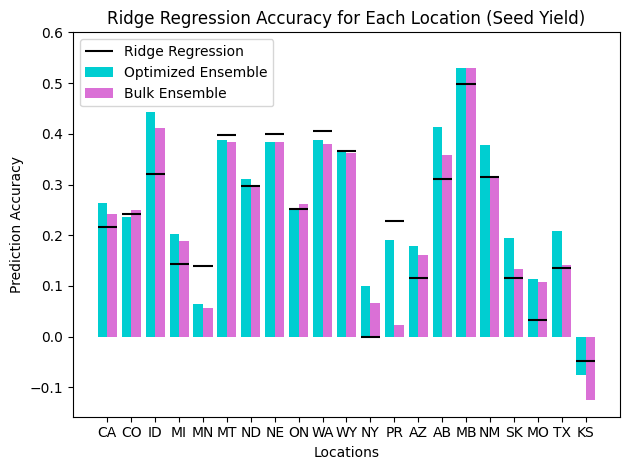

In [ ]:
Result=pd.concat([optimRRensemble,simpleRR,simpleRRensemble],axis=1)
Result.columns= ["Location","optimRREnsemble","RR","simpleRRensemble"]

# Set plot parameters
fig, ax = plt.subplots()
width = 0.4 # width of bar
x = np.arange(len(Result["Location"]))  # Use numerical x-positions for the bars

ax.bar(x, Result["optimRREnsemble"], width, color="darkturquoise",label = 'Optimized Ensemble')
ax.bar(x + width, Result["simpleRRensemble"], width, color='orchid', label='Bulk Ensemble')
ax.set_ylabel('Prediction Accuracy')
ax.set_xlabel('Locations')
ax.set_title('Ridge Regression Accuracy for Each Location (Seed Yield)')
ax.set_xticks(x + width / 2)  # Set x-tick positions in the middle of the grouped bars
ax.set_xticklabels(Result["Location"])  # Set x-tick labels to location names
ax.set_ylim(top=0.6)
ax.hlines(Result['RR'],xmin=x-0.2,xmax=x+0.6,colors="black",label ="Ridge Regression")
ax.legend()



fig.tight_layout()


(3) NEURAL NETWORK

In [ ]:

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.BatchNorm1d(hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.BatchNorm1d(hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, 1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

train neural network

In [ ]:

def trainLoop():
  # Run the training loop
  for epoch in range(0, 1): # 5 epochs at maximum
    step_loss = []

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))

      # Zero the gradients
      optimizer.zero_grad()

      # Perform forward pass
      outputs = model(inputs)

      # Compute loss
      loss = loss_fn(outputs, targets)
      collect_loss.append(loss)



      # Perform backward pass
      loss.backward()

      # Perform optimization
      optimizer.step()
      step_loss.append(loss.item())
      # Print statistics
      current_loss += loss.item()
      if i % 10 == 0:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0
    step_loss = np.array(step_loss)
    collect_loss.append(step_loss.mean())

  # Process is complete.
  print('Training process has finished.')


NEURAL NETWORK 5 fold CV

In [ ]:
results = []

traits = ["SY","SW","DF","DM"]



for trait in traits:

  data = pd.read_csv("fullDataset"+trait+".csv")
  data = data.drop(list(data)[0:2], axis=1) #remove useless columns
  X = data.drop(["1","2","3"], axis=1)
  X = np.array(X.replace({0.0:-1,int(1.0):0,2.0:int(1)}))
  y = np.array(data["3"])

  dataset = CDBNDataset(X, y)
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1,drop_last=True)

  input_dim = len(data.columns) -3
  hidden_dim = 2000
  output_dim = 1

  scores=[] #to store r squared
  rmse_list=[] #to store RMSE
  lrmodel = LinearRegression()
  cv = KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in cv.split(X):

      X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
      X_Test = torch.from_numpy(X_test).float()
      y_test = torch.from_numpy(y_test).float()


      model = MLP()
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
      num_epochs = 2

      collect_loss = []
      trainLoop()
      predictions = model(X_Test)
      truth = (y_test)

      predictions = predictions.detach().numpy()
      truth = truth.detach().numpy()
      truth = truth.reshape(y_test.shape[0],1)
      predictions = pd.DataFrame(predictions)
      truth = pd.DataFrame(truth)

      performance = predictions.corrwith(truth,axis = 0)
      scores.append(performance)
      rmse_fold = mean_squared_error(y_test,predictions)
      rmse_list.append(rmse_fold)

  scores = np.array(scores)
  scores = mean(scores.flatten())
  results.append(scores)

results = pd.DataFrame(results)
traits = pd.DataFrame(traits)

final = pd.concat([traits, results], axis=1)
final.to_csv("NN_Results.csv")



data = pd.read_csv("fullDatasetSY.csv")
envs = data["1"].unique()
scores = []

#Baseline Performance for each test env with all locations included in ens
for env in envs:
  testData = data[data["1"] == env] #test data = one environment
  x_test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_test = testData["3"] #only pheno
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  X_train = trainData.drop(["Unnamed: 0","0","1","2","3"], axis=1)
  y_train = trainData["3"] #only pheno


  model = MLP()
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  num_epochs = 2

  collect_loss = []
  trainLoop()
  predictions = model(X_Test)
  truth = (y_test)

  predictions = predictions.detach().numpy()
  truth = truth.detach().numpy()
  truth = truth.reshape(y_test.shape[0],1)
  predictions = pd.DataFrame(predictions)
  truth = pd.DataFrame(truth)

  performance = predictions.corrwith(truth,axis = 0)
  scores.append(performance)
  rmse_fold = mean_squared_error(y_test,predictions)
  rmse_list.append(rmse_fold)

  predictions = np.array(predictions)
  truth = np.array(y_test)
  accuracy = np.corrcoef(predictions,truth)
  accuracy = accuracy[0,1]
  scores.append(accuracy)



allAccuracies = pd.DataFrame(scores)
envs = pd.DataFrame(envs)
baselines = pd.concat([envs, allAccuracies], axis=1)

simpleRR = baselines.iloc[:,1]

Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 15780.630
Loss after mini-batch    11: 65580.064
Loss after mini-batch    21: 34519.609
Loss after mini-batch    31: 26733.946
Loss after mini-batch    41: 29434.057
Loss after mini-batch    51: 18942.001
Loss after mini-batch    61: 15188.468
Loss after mini-batch    71: 21563.287
Loss after mini-batch    81: 25828.819
Loss after mini-batch    91: 21576.157
Loss after mini-batch   101: 26129.290
Loss after mini-batch   111: 18524.794
Loss after mini-batch   121: 29491.887
Loss after mini-batch   131: 22852.529
Loss after mini-batch   141: 29000.544
Loss after mini-batch   151: 22567.823
Loss after mini-batch   161: 19267.253
Loss after mini-batch   171: 22863.596
Loss after mini-batch   181: 21389.581
Loss after mini-batch   191: 18267.722
Loss after mini-batch   201: 26218.603
Loss after mini-batch   211: 25423.855
Loss after mini-batch   221: 22395.834
Loss after mini-batch   231: 21729.341
Loss after mini-batch   241: 20317.078
Loss after mini-batch   2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 11573.655
Loss after mini-batch    11: 86814.919
Loss after mini-batch    21: 46342.741
Loss after mini-batch    31: 29709.050
Loss after mini-batch    41: 24498.381
Loss after mini-batch    51: 29568.699
Loss after mini-batch    61: 25111.676
Loss after mini-batch    71: 20951.549
Loss after mini-batch    81: 24139.106
Loss after mini-batch    91: 24789.410
Loss after mini-batch   101: 15792.484
Loss after mini-batch   111: 17213.650
Loss after mini-batch   121: 19922.137
Loss after mini-batch   131: 17234.337
Loss after mini-batch   141: 22118.624
Loss after mini-batch   151: 25401.281
Loss after mini-batch   161: 30178.599
Loss after mini-batch   171: 24945.501
Loss after mini-batch   181: 23480.482
Loss after mini-batch   191: 19385.218
Loss after mini-batch   201: 22090.991
Loss after mini-batch   211: 20297.896
Loss after mini-batch   221: 16620.133
Loss after mini-batch   231: 22303.675
Loss after mini-batch   241: 20718.503
Loss after mini-batch   2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 11849.738
Loss after mini-batch    11: 78946.766
Loss after mini-batch    21: 32290.445
Loss after mini-batch    31: 31033.166
Loss after mini-batch    41: 25682.714
Loss after mini-batch    51: 22145.974
Loss after mini-batch    61: 22361.713
Loss after mini-batch    71: 26002.329
Loss after mini-batch    81: 23773.610
Loss after mini-batch    91: 25396.805
Loss after mini-batch   101: 18712.848
Loss after mini-batch   111: 23282.443
Loss after mini-batch   121: 24611.590
Loss after mini-batch   131: 26007.197
Loss after mini-batch   141: 19691.479
Loss after mini-batch   151: 24833.566
Loss after mini-batch   161: 22123.487
Loss after mini-batch   171: 20003.551
Loss after mini-batch   181: 19111.314
Loss after mini-batch   191: 21519.363
Loss after mini-batch   201: 24124.349
Loss after mini-batch   211: 26146.092
Loss after mini-batch   221: 19199.991
Loss after mini-batch   231: 22161.177
Loss after mini-batch   241: 24841.759
Loss after mini-batch   2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 10756.874
Loss after mini-batch    11: 91383.799
Loss after mini-batch    21: 28390.890
Loss after mini-batch    31: 20571.179
Loss after mini-batch    41: 21767.024
Loss after mini-batch    51: 21867.473
Loss after mini-batch    61: 25984.014
Loss after mini-batch    71: 25750.679
Loss after mini-batch    81: 21816.194
Loss after mini-batch    91: 23082.510
Loss after mini-batch   101: 23947.917
Loss after mini-batch   111: 20885.455
Loss after mini-batch   121: 23920.662
Loss after mini-batch   131: 22241.546
Loss after mini-batch   141: 18136.290
Loss after mini-batch   151: 22327.026
Loss after mini-batch   161: 21844.604
Loss after mini-batch   171: 24200.429
Loss after mini-batch   181: 17797.474
Loss after mini-batch   191: 19834.000
Loss after mini-batch   201: 22222.140
Loss after mini-batch   211: 27341.902
Loss after mini-batch   221: 25473.140
Loss after mini-batch   231: 22681.095
Loss after mini-batch   241: 22781.194
Loss after mini-batch   2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 18925.078
Loss after mini-batch    11: 82916.250
Loss after mini-batch    21: 36164.266
Loss after mini-batch    31: 31658.714
Loss after mini-batch    41: 29473.517
Loss after mini-batch    51: 27131.011
Loss after mini-batch    61: 18449.966
Loss after mini-batch    71: 22376.222
Loss after mini-batch    81: 26856.066
Loss after mini-batch    91: 20650.576
Loss after mini-batch   101: 22723.914
Loss after mini-batch   111: 19093.801
Loss after mini-batch   121: 18550.343
Loss after mini-batch   131: 16826.217
Loss after mini-batch   141: 24894.414
Loss after mini-batch   151: 23158.574
Loss after mini-batch   161: 17688.527
Loss after mini-batch   171: 23801.702
Loss after mini-batch   181: 19440.256
Loss after mini-batch   191: 17763.281
Loss after mini-batch   201: 22505.530
Loss after mini-batch   211: 21163.535
Loss after mini-batch   221: 23258.500
Loss after mini-batch   231: 21211.436
Loss after mini-batch   241: 22628.840
Loss after mini-batch   2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 276.691
Loss after mini-batch    11: 564.368
Loss after mini-batch    21: 391.027
Loss after mini-batch    31: 195.880
Loss after mini-batch    41: 192.410
Loss after mini-batch    51: 248.501
Loss after mini-batch    61: 220.740
Loss after mini-batch    71: 170.122
Loss after mini-batch    81: 132.100
Loss after mini-batch    91: 106.195
Loss after mini-batch   101: 141.216
Loss after mini-batch   111: 133.120
Loss after mini-batch   121: 196.205
Loss after mini-batch   131: 121.672
Loss after mini-batch   141: 112.200
Loss after mini-batch   151: 141.192
Loss after mini-batch   161: 132.621
Loss after mini-batch   171: 110.697
Loss after mini-batch   181: 162.271
Loss after mini-batch   191: 108.523
Loss after mini-batch   201: 135.833
Loss after mini-batch   211: 114.827
Loss after mini-batch   221: 114.107
Loss after mini-batch   231: 134.312
Loss after mini-batch   241: 112.712
Loss after mini-batch   251: 141.697
Loss after mini-batch   261: 186.850
L

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   391: 100.058
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 188.557
Loss after mini-batch    11: 889.359
Loss after mini-batch    21: 389.981
Loss after mini-batch    31: 262.807
Loss after mini-batch    41: 350.881
Loss after mini-batch    51: 235.928
Loss after mini-batch    61: 206.296
Loss after mini-batch    71: 207.801
Loss after mini-batch    81: 158.065
Loss after mini-batch    91: 134.618
Loss after mini-batch   101: 125.009
Loss after mini-batch   111: 171.804
Loss after mini-batch   121: 168.217
Loss after mini-batch   131: 211.258
Loss after mini-batch   141: 143.308
Loss after mini-batch   151: 159.109
Loss after mini-batch   161: 140.284
Loss after mini-batch   171: 151.051
Loss after mini-batch   181: 95.710
Loss after mini-batch   191: 144.972
Loss after mini-batch   201: 135.226
Loss after mini-batch   211: 113.482
Loss after mini-batch   221: 119.576
Loss after mini-batch   231: 170.415
Loss after mini-batch   241: 97.774
Loss after mini-batch   251: 145.330
Loss after mini-batch   261: 92.580
Loss

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 270.989
Loss after mini-batch    11: 567.084
Loss after mini-batch    21: 242.474
Loss after mini-batch    31: 318.175
Loss after mini-batch    41: 296.624
Loss after mini-batch    51: 267.992
Loss after mini-batch    61: 220.372
Loss after mini-batch    71: 145.851
Loss after mini-batch    81: 104.411
Loss after mini-batch    91: 91.835
Loss after mini-batch   101: 98.681
Loss after mini-batch   111: 119.117
Loss after mini-batch   121: 101.822
Loss after mini-batch   131: 94.638
Loss after mini-batch   141: 114.530
Loss after mini-batch   151: 71.016
Loss after mini-batch   161: 102.666
Loss after mini-batch   171: 140.524
Loss after mini-batch   181: 191.543
Loss after mini-batch   191: 107.993
Loss after mini-batch   201: 107.003
Loss after mini-batch   211: 147.370
Loss after mini-batch   221: 150.288
Loss after mini-batch   231: 83.671
Loss after mini-batch   241: 109.408
Loss after mini-batch   251: 92.505
Loss after mini-batch   261: 148.048
Loss af

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   391: 57.081
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 234.478
Loss after mini-batch    11: 957.462
Loss after mini-batch    21: 385.766
Loss after mini-batch    31: 215.808
Loss after mini-batch    41: 138.727
Loss after mini-batch    51: 126.534
Loss after mini-batch    61: 113.561
Loss after mini-batch    71: 102.957
Loss after mini-batch    81: 157.084
Loss after mini-batch    91: 194.366
Loss after mini-batch   101: 172.028
Loss after mini-batch   111: 166.585
Loss after mini-batch   121: 130.815
Loss after mini-batch   131: 173.437
Loss after mini-batch   141: 103.750
Loss after mini-batch   151: 194.938
Loss after mini-batch   161: 149.298
Loss after mini-batch   171: 141.116
Loss after mini-batch   181: 133.650
Loss after mini-batch   191: 138.762
Loss after mini-batch   201: 128.812
Loss after mini-batch   211: 86.842
Loss after mini-batch   221: 76.487
Loss after mini-batch   231: 125.019
Loss after mini-batch   241: 81.589
Loss after mini-batch   251: 85.538
Loss after mini-batch   261: 97.105
Loss a

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   391: 172.828
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 268.650
Loss after mini-batch    11: 740.237
Loss after mini-batch    21: 274.418
Loss after mini-batch    31: 154.292
Loss after mini-batch    41: 163.351
Loss after mini-batch    51: 262.065
Loss after mini-batch    61: 141.602
Loss after mini-batch    71: 130.338
Loss after mini-batch    81: 205.926
Loss after mini-batch    91: 188.356
Loss after mini-batch   101: 165.774
Loss after mini-batch   111: 301.664
Loss after mini-batch   121: 135.149
Loss after mini-batch   131: 151.326
Loss after mini-batch   141: 162.840
Loss after mini-batch   151: 155.286
Loss after mini-batch   161: 262.392
Loss after mini-batch   171: 198.540
Loss after mini-batch   181: 127.178
Loss after mini-batch   191: 67.539
Loss after mini-batch   201: 91.055
Loss after mini-batch   211: 104.735
Loss after mini-batch   221: 87.315
Loss after mini-batch   231: 89.450
Loss after mini-batch   241: 119.319
Loss after mini-batch   251: 154.900
Loss after mini-batch   261: 143.508
Loss 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 4.888
Loss after mini-batch    11: 31.239
Loss after mini-batch    21: 7.279
Loss after mini-batch    31: 6.099
Loss after mini-batch    41: 2.637
Loss after mini-batch    51: 1.979
Loss after mini-batch    61: 1.753
Loss after mini-batch    71: 1.617
Loss after mini-batch    81: 1.157


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    91: 1.323
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 4.266
Loss after mini-batch    11: 29.698
Loss after mini-batch    21: 8.187
Loss after mini-batch    31: 2.507
Loss after mini-batch    41: 1.754
Loss after mini-batch    51: 1.653
Loss after mini-batch    61: 1.194
Loss after mini-batch    71: 1.632
Loss after mini-batch    81: 1.753


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    91: 1.218
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 6.271
Loss after mini-batch    11: 27.607
Loss after mini-batch    21: 5.196
Loss after mini-batch    31: 3.973
Loss after mini-batch    41: 2.323
Loss after mini-batch    51: 2.338
Loss after mini-batch    61: 1.096
Loss after mini-batch    71: 1.033
Loss after mini-batch    81: 1.414
Loss after mini-batch    91: 1.334
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 3.727
Loss after mini-batch    11: 28.225
Loss after mini-batch    21: 6.991
Loss after mini-batch    31: 4.520
Loss after mini-batch    41: 2.487
Loss after mini-batch    51: 1.150
Loss after mini-batch    61: 1.181
Loss after mini-batch    71: 1.236
Loss after mini-batch    81: 1.480


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    91: 1.187
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 4.435
Loss after mini-batch    11: 19.140
Loss after mini-batch    21: 6.480
Loss after mini-batch    31: 2.543
Loss after mini-batch    41: 1.942
Loss after mini-batch    51: 1.703
Loss after mini-batch    61: 1.635
Loss after mini-batch    71: 1.020
Loss after mini-batch    81: 1.583
Loss after mini-batch    91: 1.588
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 17.591
Loss after mini-batch    11: 44.645
Loss after mini-batch    21: 15.826
Loss after mini-batch    31: 12.126
Loss after mini-batch    41: 4.615
Loss after mini-batch    51: 4.342
Loss after mini-batch    61: 3.541
Loss after mini-batch    71: 3.938
Loss after mini-batch    81: 4.594
Loss after mini-batch    91: 2.532
Loss after mini-batch   101: 3.401
Loss after mini-batch   111: 3.781
Loss after mini-batch   121: 3.594
Loss after mini-batch   131: 3.968
Loss after mini-batch   141: 3.453
Loss after mini-batch   151: 4.291
Loss after mini-batch   161: 3.665
Loss after mini-batch   171: 2.799
Loss after mini-batch   181: 3.268
Loss after mini-batch   191: 5.141
Loss after mini-batch   201: 7.779
Loss after mini-batch   211: 3.947
Loss after mini-batch   221: 2.952
Loss after mini-batch   231: 2.667
Loss after mini-batch   241: 3.294
Loss after mini-batch   251: 3.367
Loss after mini-batch   261: 2.945
Loss after mini-batch   271: 2.887
Loss after mini-

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   351: 2.807
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 17.778
Loss after mini-batch    11: 54.952
Loss after mini-batch    21: 27.392
Loss after mini-batch    31: 11.976
Loss after mini-batch    41: 6.409
Loss after mini-batch    51: 5.281
Loss after mini-batch    61: 5.196
Loss after mini-batch    71: 5.089
Loss after mini-batch    81: 4.468
Loss after mini-batch    91: 4.496
Loss after mini-batch   101: 3.528
Loss after mini-batch   111: 3.568
Loss after mini-batch   121: 3.317
Loss after mini-batch   131: 4.252
Loss after mini-batch   141: 4.633
Loss after mini-batch   151: 3.049
Loss after mini-batch   161: 3.713
Loss after mini-batch   171: 3.416
Loss after mini-batch   181: 3.084
Loss after mini-batch   191: 3.781
Loss after mini-batch   201: 4.146
Loss after mini-batch   211: 3.672
Loss after mini-batch   221: 4.543
Loss after mini-batch   231: 4.536
Loss after mini-batch   241: 3.379
Loss after mini-batch   251: 4.023
Loss after mini-batch   261: 3.095
Loss after mini-batch   271: 3.645
Loss after mini-

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   351: 3.321
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 20.317
Loss after mini-batch    11: 36.622
Loss after mini-batch    21: 17.570
Loss after mini-batch    31: 10.160
Loss after mini-batch    41: 11.388
Loss after mini-batch    51: 5.403
Loss after mini-batch    61: 5.086
Loss after mini-batch    71: 3.501
Loss after mini-batch    81: 3.422
Loss after mini-batch    91: 2.861
Loss after mini-batch   101: 3.971
Loss after mini-batch   111: 3.382
Loss after mini-batch   121: 3.605
Loss after mini-batch   131: 3.517
Loss after mini-batch   141: 4.012
Loss after mini-batch   151: 3.316
Loss after mini-batch   161: 3.960
Loss after mini-batch   171: 2.976
Loss after mini-batch   181: 3.424
Loss after mini-batch   191: 3.150
Loss after mini-batch   201: 3.646
Loss after mini-batch   211: 2.812
Loss after mini-batch   221: 3.181
Loss after mini-batch   231: 3.561
Loss after mini-batch   241: 4.275
Loss after mini-batch   251: 3.244
Loss after mini-batch   261: 3.640
Loss after mini-batch   271: 4.421
Loss after mini

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   351: 4.346
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 22.275
Loss after mini-batch    11: 105.993
Loss after mini-batch    21: 33.031
Loss after mini-batch    31: 13.043
Loss after mini-batch    41: 8.708
Loss after mini-batch    51: 4.455
Loss after mini-batch    61: 3.544
Loss after mini-batch    71: 2.875
Loss after mini-batch    81: 4.434
Loss after mini-batch    91: 4.303
Loss after mini-batch   101: 3.662
Loss after mini-batch   111: 4.386
Loss after mini-batch   121: 4.047
Loss after mini-batch   131: 4.596
Loss after mini-batch   141: 2.911
Loss after mini-batch   151: 2.841
Loss after mini-batch   161: 3.238
Loss after mini-batch   171: 3.567
Loss after mini-batch   181: 3.579
Loss after mini-batch   191: 3.860
Loss after mini-batch   201: 2.536
Loss after mini-batch   211: 3.765
Loss after mini-batch   221: 2.873
Loss after mini-batch   231: 3.131
Loss after mini-batch   241: 3.078
Loss after mini-batch   251: 3.490
Loss after mini-batch   261: 2.912
Loss after mini-batch   271: 3.377
Loss after mini

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   351: 2.975
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 17.214
Loss after mini-batch    11: 58.981
Loss after mini-batch    21: 24.109
Loss after mini-batch    31: 11.727
Loss after mini-batch    41: 5.732
Loss after mini-batch    51: 5.728
Loss after mini-batch    61: 3.422
Loss after mini-batch    71: 5.444
Loss after mini-batch    81: 5.386
Loss after mini-batch    91: 5.016
Loss after mini-batch   101: 3.929
Loss after mini-batch   111: 2.332
Loss after mini-batch   121: 3.379
Loss after mini-batch   131: 2.931
Loss after mini-batch   141: 2.643
Loss after mini-batch   151: 4.354
Loss after mini-batch   161: 3.841
Loss after mini-batch   171: 6.543
Loss after mini-batch   181: 5.944
Loss after mini-batch   191: 3.811
Loss after mini-batch   201: 2.583
Loss after mini-batch   211: 4.476
Loss after mini-batch   221: 5.047
Loss after mini-batch   231: 3.763
Loss after mini-batch   241: 3.679
Loss after mini-batch   251: 3.318
Loss after mini-batch   261: 3.026
Loss after mini-batch   271: 3.513
Loss after mini-

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch   351: 2.766
Training process has finished.


View accuracy

In [ ]:
scores = np.array(scores)
print("the accuracy is",mean(scores.flatten()))

the accuracy is 0.43296505049945594


Plot training loss (on last fold)

In [ ]:
plt.plot(step_loss, label='train_loss')
plt.title("Training Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Training Iteration")
plt.show


NameError: name 'step_loss' is not defined

ENSEMBLE NEURAL NET ACROSS ENVIRONMENTS

In [ ]:
#Ensemble across environments
data = pd.read_csv("fullDatasetSW.csv")
lowObs = ["MN","MT","AZ","AB","MB","NM","SK","TX"] #drop envs with few obs

for env in lowObs:
  data = data.drop(data[data['1'] == env].index)

hidden_dim = 2000
output_dim = 1

envs = data["1"].unique()
scores=[] #to store r squared
allAccuracies = []
rmse_list=[] #to store RMSE

for env in envs:
  testData = data[data["1"] == env] #pull out test env
  trainData = data.drop(data[data['1'] == env].index) #remove test env from training
  x_Test = testData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #only geno
  y_Test = testData["3"] #only pheno  input_dim = len(x_Test.columns)
  input_dim = len(x_Test.columns)


  predictions = pd.DataFrame() #empty df to prediction on current env
  locs = trainData["1"].unique() #new list of locs for training loc ens

  for loc in locs:
    ensData = trainData[trainData["1"] == loc] #take one environment for training
    x_Train = ensData.drop(["Unnamed: 0","0","1","2","3"], axis=1) #geno only
    y_Train = ensData["3"] #pheno only

    x_Test = np.array(x_Test,dtype=np.float16)
    y_Test = np.array(y_Test,dtype=np.float16)
    x_Train = np.array(x_Train,dtype=np.float16)
    y_Train = np.array(y_Train,dtype=np.float16)

    dataset = CDBNDataset(x_Train, y_Train)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True, num_workers=1,drop_last=True)

    x_Test = torch.from_numpy(x_Test).float()
    y_Test = torch.from_numpy(y_Test).float()
    #x_Train = torch.from_numpy(x_Train).float()
    #y_Train = torch.from_numpy(y_Train).float()

    model = MLP()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    num_epochs = 10

    collect_loss = []
    trainLoop()
    prediction = model(x_Test)
    prediction = prediction.detach().numpy()
    prediction = pd.DataFrame(prediction)
    predictions = pd.concat([predictions,prediction],axis=1) #collect predictions for every model in ens
    finalPredLoc = predictions.mean(axis=1)
    finalPredLoc = np.array(finalPredLoc) #turn to df
    truth = np.array(y_Test) #re-name ground truth
    accuracy = np.corrcoef(truth,finalPredLoc)

  allAccuracies.append(accuracy[0,1]) #collect acc for env 1



Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 260.369
Loss after mini-batch    11: 587.938


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 308.264
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 271.477
Loss after mini-batch    11: 734.353


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 291.874
Loss after mini-batch    11: 619.332


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 178.516
Loss after mini-batch    11: 588.692


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 232.022
Loss after mini-batch    11: 775.261


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 222.549
Loss after mini-batch    11: 545.847


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 222.679
Loss after mini-batch    11: 520.122


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 293.339
Loss after mini-batch    11: 668.503


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 162.983
Loss after mini-batch    11: 556.887


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 228.859
Loss after mini-batch    11: 659.683


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 340.178
Loss after mini-batch    11: 748.294


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 208.759
Loss after mini-batch    11: 651.717


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 228.057
Loss after mini-batch    11: 500.921


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 296.662
Loss after mini-batch    11: 631.190


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 279.161
Loss after mini-batch    11: 586.425


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 239.155
Loss after mini-batch    11: 612.969


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 226.087
Loss after mini-batch    11: 665.522


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 218.545
Loss after mini-batch    11: 595.169


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 252.272


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    11: 430.120
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 209.124
Loss after mini-batch    11: 587.155


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 252.619
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 240.424
Loss after mini-batch    11: 502.116
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 230.348
Loss after mini-batch    11: 593.477


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 215.269
Loss after mini-batch    11: 798.980


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 293.282
Loss after mini-batch    11: 561.443


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 322.491
Loss after mini-batch    11: 546.699


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 253.322
Loss after mini-batch    11: 686.772


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 283.223
Loss after mini-batch    11: 639.859


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 244.266
Loss after mini-batch    11: 594.925


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 267.466
Loss after mini-batch    11: 545.099


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 262.558
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 331.800
Loss after mini-batch    11: 752.239


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 207.889
Loss after mini-batch    11: 572.997
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 222.249
Loss after mini-batch    11: 840.268


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 246.966
Loss after mini-batch    11: 635.033
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 272.350
Loss after mini-batch    11: 607.649


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 235.989
Loss after mini-batch    11: 715.981


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 303.025
Loss after mini-batch    11: 564.925


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 201.152
Loss after mini-batch    11: 502.536


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 262.507
Loss after mini-batch    11: 589.757


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 321.268
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 297.811
Loss after mini-batch    11: 662.793


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 215.947
Loss after mini-batch    11: 573.330


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 209.956
Loss after mini-batch    11: 465.277


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 301.349
Loss after mini-batch    11: 620.001


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 254.337
Loss after mini-batch    11: 700.687
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 232.285
Loss after mini-batch    11: 646.697


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 260.832
Loss after mini-batch    11: 592.914


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 273.355
Loss after mini-batch    11: 590.398


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 235.820
Loss after mini-batch    11: 446.423
Loss after mini-batch    21: 185.704
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 324.025
Loss after mini-batch    11: 677.002
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 263.754
Loss after mini-batch    11: 696.533


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 308.250
Loss after mini-batch    11: 561.757


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 244.359
Loss after mini-batch    11: 589.223


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 249.302
Loss after mini-batch    11: 418.760


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 215.373
Loss after mini-batch    11: 619.709


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 208.283
Loss after mini-batch    11: 614.207


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 219.042
Loss after mini-batch    11: 604.190


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 271.841
Loss after mini-batch    11: 657.315


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 342.068
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 288.323
Loss after mini-batch    11: 633.702


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 240.720
Loss after mini-batch    11: 561.720
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 309.058
Loss after mini-batch    11: 498.091


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 291.128
Loss after mini-batch    11: 739.392


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 204.357
Loss after mini-batch    11: 709.314


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 371.198
Loss after mini-batch    11: 755.151


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 178.022
Loss after mini-batch    11: 590.956


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 299.512
Loss after mini-batch    11: 497.797
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 257.315
Loss after mini-batch    11: 590.975


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 249.022
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 256.937
Loss after mini-batch    11: 884.256


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 268.138
Loss after mini-batch    11: 707.514


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 225.175
Loss after mini-batch    11: 481.469


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 309.868
Loss after mini-batch    11: 684.975


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 278.155
Loss after mini-batch    11: 666.957


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 260.803
Loss after mini-batch    11: 630.146
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 309.011
Loss after mini-batch    11: 570.015


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 271.964
Loss after mini-batch    11: 457.024


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 238.787
Loss after mini-batch    11: 616.369


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 306.944
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 246.294
Loss after mini-batch    11: 606.943


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 194.336
Loss after mini-batch    11: 411.852


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 231.394
Loss after mini-batch    11: 536.723


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 325.561
Loss after mini-batch    11: 971.270


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 256.070
Loss after mini-batch    11: 550.276
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 235.864
Loss after mini-batch    11: 720.758


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 237.077
Loss after mini-batch    11: 855.878


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 237.967
Loss after mini-batch    11: 468.687


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 263.002
Loss after mini-batch    11: 602.341


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch    21: 242.964
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 237.008
Loss after mini-batch    11: 889.833


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 225.989
Loss after mini-batch    11: 340.470


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 208.862
Loss after mini-batch    11: 615.680


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 302.036
Loss after mini-batch    11: 781.852


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 245.225
Loss after mini-batch    11: 709.972
Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 267.331
Loss after mini-batch    11: 694.093


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.
Starting epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss after mini-batch     1: 291.433
Loss after mini-batch    11: 538.095


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training process has finished.


View Accuracy

In [ ]:
allAccuracies = np.array(allAccuracies)
print("the accuracy is",mean(allAccuracies.flatten()))


the accuracy is 0.8838825067349934


(3) TRANSFORMER

In [ ]:
geno = data.drop(['1','2','3'],axis=1)

nSNPs = nSNPs-1

xTrain = torch.from_numpy(xTrain)
xTest = torch.from_numpy(xTest)
yTrain = torch.from_numpy(yTrain)
yTest = torch.from_numpy(yTest)

compute attention between each pair of inputs

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

Feedforward

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        self.pe = self.pe[:, :x.size(1)]
        return x + self.pe[:, :x.size(1)]

Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

Forward

In [ ]:
def forward(self, x, enc_output, src_mask, tgt_mask):
    attn_output = self.self_attn(x, x, x, tgt_mask)
    x = self.norm1(x + self.dropout(attn_output))
    attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
    x = self.norm2(x + self.dropout(attn_output))
    ff_output = self.feed_forward(x)
    x = self.norm3(x + self.dropout(ff_output))
    return x

Define Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        output = self.fc(enc_output)
        return output

Training

In [ ]:
src_vocab_size = nSNPs
tgt_vocab_size = 1
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = xTrain #must reshape to (1,nSNPs,(batch size, max_seq_lenght))
src_data = src_data.long()
tgt_data = yTrain.unsqueeze(1) # 1,1,(batch size, max_seq_lenght))

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.1)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Eval

In [ ]:
transformer.eval()

# Generate random sample validation data
val_src_data = xTest
val_tgt_data = yTest

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")



In [ ]:
traits = ["SY","SW","DF","DM"]

for trait in traits:
  print("fullDataset",trait,".csv",sep="")

traits = pd.DataFrame(traits)

x = 1
y = 2
z = 3
w = 4

test = []

test.append(x)
test.append(y)
test.append(z)
test.append(w)

traits = pd.DataFrame(traits)
test = pd.DataFrame(test)

final = pd.concat([traits,test],axis=1)

final

trait = traits[0]

data = print("fullDataset"+trait+".csv")

fullDatasetSY.csv
